# Manual Selection Cuts
Now we have made our neural networks and other MVA models we can make some better manual cuts. So this notebook quickly goes through some of them.

In [1]:
import numpy as np
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import uproot as up
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

2022-04-06 12:45:48.240120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 12:45:48.240191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


## Gather Data

In [2]:
df = pd.read_csv('../data_files/9.0.1/all.csv', index_col=[0])
# Not normalised but has had preselection applied

## Plot Feature Distributions

In [3]:
NUMBER_OF_BINS = 50
FEATURE = df.columns[8]
STD_DEVS = 5

LN_Lb_IP_OWNPV


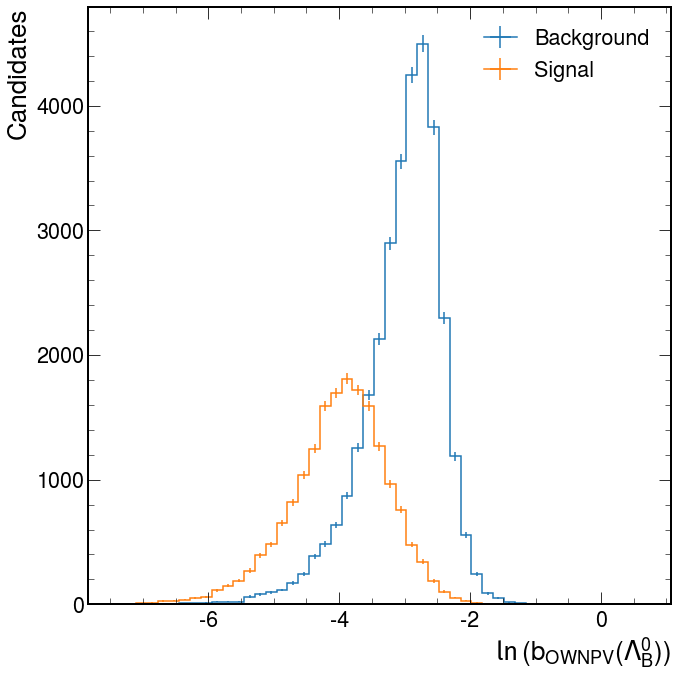

In [4]:
print(FEATURE)
# Define a reasonable bin-space that is +- 5 standard deviations from the mean value of the feature
bins = np.linspace(np.mean(df[FEATURE])-(STD_DEVS*np.std(df[FEATURE])), np.mean(df[FEATURE])+(STD_DEVS*np.std(df[FEATURE])), NUMBER_OF_BINS)

# Or hard override after looking at it
#bins = np.linspace(-20, 20, 50)

fig, ax = plt.subplots(1, 1)
bg, _ = np.histogram(df[FEATURE][np.logical_and(df['category']==0, df['IsSimulated']==False)], bins=bins)
sig, _ = np.histogram(df[FEATURE][df['category']==1], bins=bins)
hep.histplot([bg, sig], yerr=True, bins=bins, ax=ax, label=['Background', 'Signal'])
#plt.xlabel(f"{FEATURE} value")
plt.xlabel(r"$\ln{(b_{OWNPV}(\Lambda_B^0))}$")
plt.ylabel("Candidates")
plt.legend()
plt.tight_layout()
#plt.savefig('../images/ManualCuts/LN_Lb_IP_OWNPV_BgVsSig.png')
plt.show()

# Punzi Scan

In [5]:
class MyCubic(zfit.pdf.ZPDF):
    _PARAMS = ['p0', 'p1', 'p2', 'p3', 'shift']

    def _unnormalized_pdf(self, x):
       x = z.unstack_x(x)
       p0 = self.params['p0']
       p1 = self.params['p1']
       p2 = self.params['p2']
       p3 = self.params['p3']
       shift = self.params['shift']
       return p3*(x-shift)**3 + p2*(x-shift)**2 + p1*(x-shift) + p0

def CubicIntegral(limits, params, model):
   (lower,), (upper,) = limits.limits
   p1 = params['p1']
   p2 = params['p2']
   p3 = params['p3']
   shift = params['shift']
   return (3*p3*(upper-shift)**2 + 2*p2*upper) - (3*p3*(lower-shift)**2 + 2*p2*lower)

# Register the integrals
limits = zfit.Space.from_axes(axes=0, limits=(zfit.Space.ANY_LOWER, zfit.Space.ANY_UPPER))
MyCubic.register_analytic_integral(func=CubicIntegral, limits=limits)

def fitCub(np_data, label, param_ranges, mass_ranges=[4600, 5200, 5800, 6400]):
    lowerSB = zfit.Space("Lb_M",(mass_ranges[0],mass_ranges[1]))
    upperSB = zfit.Space("Lb_M",(mass_ranges[2],mass_ranges[3]))
    massSbSpace = lowerSB + upperSB
    
    LbM = zfit.Data.from_numpy(obs=massSbSpace, array=np_data)
    
    p3 = zfit.Parameter('p3_%s'%label, -1.1515201462719907e-09, 0, 0.1)
    p2 = zfit.Parameter('p2_%s'%label, 1.407709468111769e-05, 0, 0.1)
    p1 = zfit.Parameter('p1_%s'%label, -0.2944208228095719, -0.4, 0)
    p0 = zfit.Parameter('p0_%s'%label, 292.63288141511055, 280, 300)
    shift = zfit.Parameter('shift_%s'%label, 5763.025336526583, 5700, 5800)
    
    cubic = MyCubic(obs=massSbSpace, p0=p0, p1=p1, p2=p2, p3=p3, shift=shift)
    
    cubic_yield = zfit.Parameter('yield_%s'%label, *param_ranges, step_size=1)
    cubic_ext = cubic.create_extended(cubic_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(cubic_ext, LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    fitResult = minimizerDCB.minimize(nll_ext_dcb, params=[cubic_yield])
    # Only allow floating of the yield
    
    return cubic_ext, fitResult, LbM

def fitDoubleCB(np_data, label, mass_ranges=[4600, 6400], param_ranges=[17000, 0, 100000]):
    massObsMC = zfit.Space("Lb_M", limits=(mass_ranges[0], mass_ranges[1]))
    MC_LbM = zfit.Data.from_numpy(obs=massObsMC, array=np_data)
    
    mu_CB = zfit.Parameter('mu_CB_%s'%label, 5612, 5590, 5640)
    sigma_CB = zfit.Parameter('sigma_CB_%s'%label, 21.99, 20, 23)
    alpha_l = zfit.Parameter('alpha_l_%s'%label, 0.4656, 0, 0.7)
    n_l = zfit.Parameter('n_l_%s'%label, 2.869, 2, 3.2)
    alpha_r = zfit.Parameter('alpha_r_%s'%label, 1.219, 1, 2)
    n_r = zfit.Parameter('n_r_%s'%label, 1.896, 1, 2)
    
    dcb = zfit.pdf.DoubleCB(obs=massObsMC, mu=mu_CB, sigma=sigma_CB, alphal=alpha_l, nl=n_l, alphar=alpha_r, nr=n_r)
    
    dcb_yield = zfit.Parameter('yield_%s'%label, *param_ranges, step_size=1)
    dcb_ext = dcb.create_extended(dcb_yield)
    nll_ext_dcb = zfit.loss.ExtendedUnbinnedNLL(dcb_ext, MC_LbM)
    minimizerDCB = zfit.minimize.Minuit(use_minuit_grad=True)
    try:
        fitResult = minimizerDCB.minimize(nll_ext_dcb, params=[mu_CB, sigma_CB, dcb_yield])
    except zfit.FailMinimizeNaN:
        print("Failed to minimise!")
    
    return dcb_ext, fitResult, MC_LbM

In [6]:
def get_punzi(df, cut_values, label, a=5, cut_dir='gt'):
    """
    
    DataFrame has columns of:
        correct labels | Lb_M | values | assigned class
        
    """
    
    punzis = []
    n_signal_before = np.count_nonzero(df['category'].to_numpy())
    
    for i, cut_value in enumerate(cut_values):
        if cut_dir== 'gt':
            condition = df['values'].to_numpy() > cut_value
        else:
            condition = df['values'].to_numpy() < cut_value
        cut_class = np.where(condition, 1, 0).flatten()
        df["CutClass"] = cut_class
        
        effs = np.count_nonzero(np.logical_and(cut_class==1, df['category'].to_numpy()==1)) / n_signal_before
        
        DCBMod, DCBResult, DCBTensor = fitDoubleCB(df['Lb_M'][np.logical_and(df["CutClass"]==1, df["category"]==1)].to_numpy(), f"DCB_{label}_{i}")
        expMod, expResult, expTensor = fitCub(df['Lb_M'][np.logical_and(df["CutClass"]==0, df["category"]==0)].to_numpy(), f"BG_{label}_{i}", [10000, 1, 19000])
        BGInterpRange = np.ones(2)*DCBResult.params[f"mu_CB_DCB_{label}_{i}"]['value']+np.array([-1*a, a])*DCBResult.params[f"sigma_CB_DCB_{label}_{i}"]['value']
    
        BGInterpVal=expMod.integrate(limits=BGInterpRange, norm_range=expMod.norm_range)*expResult.params[f"yield_BG_{label}_{i}"]["value"]
        
        punzi = effs / (a/2 + np.sqrt(BGInterpVal[0]))
        punzis.append(punzi)
    
    return np.array(punzis)

## Gather Punzi Data

In [18]:
cut_direction = "lt"
cut_space = np.linspace(-6, -1, 60)

In [20]:
sub_df = df[['category', 'Lb_M', FEATURE]].copy()
sub_df.columns = ['category', 'Lb_M', 'values']

punzis = get_punzi(sub_df, cut_space, FEATURE+"s", cut_dir=cut_direction)
# defined such that the cut_dir defines the signal. E.g. if value of feature > cut_value it is signal ('gt') vice versa for lt.

/home/user211/envs/scientific/lib64/python3.9/site-packages/zfit/core/integration.py:499: UserWarning: Multispace limits compare never equal to Space.
  if integ.limits >= limits


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


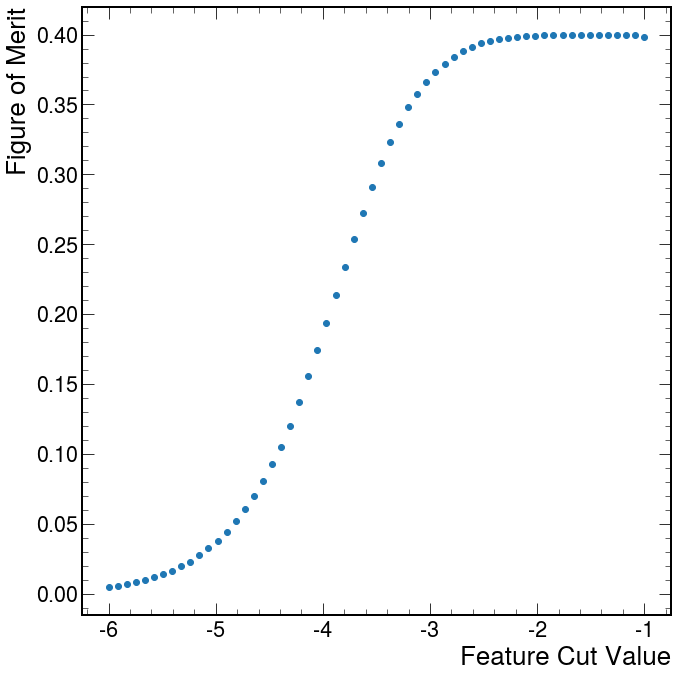

In [21]:
fig, ax = plt.subplots(1, 1)
x = cut_space
ax.scatter(x, punzis)
plt.ylabel('Figure of Merit')
plt.xlabel('Feature Cut Value')
plt.legend()
plt.tight_layout()
plt.savefig(f'../images/ManualCuts/Punzi_{FEATURE}.png')
plt.show()